In [38]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype, Normalize, RandomAffine

from matplotlib import pyplot as plt
import numpy as np
import time

In [39]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [40]:
train_transforms = transforms.Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    RandomAffine(
      degrees=10,
      translate=(0.15, 0.15),
      scale=(0.9, 1.1)
    )
])

test_transforms = transforms.Compose([
  ToImage(),
  ToDtype(torch.float32, scale=True),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [41]:
trainD = datasets.CIFAR10(root="data", train=True, transform=train_transforms, download=True)
testD = datasets.CIFAR10(root="data", train=False, transform=test_transforms, download=True)

In [43]:
BATCH_SIZE = 256
DEVICE = torch.accelerator.current_accelerator()

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [44]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.labels = {
      0: "airplane",  
      1: "automobile", 
      2: "bird",
      3: "cat",
      4: "deer",
      5: "dog",
      6: "frog",
      7: "horse",
      8: "ship",
      9: "truck"
    }
    self.model = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1), # 32x32x32
      nn.ReLU(),

      nn.Conv2d(32, 64, 3), # 29x29x64
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 14x14x64

      nn.Conv2d(64, 128, 3, padding=1), # 14x14x128
      nn.ReLU(),

      nn.Conv2d(128, 216, 5), # 10x10x216 
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 5x5x216

      nn.Flatten(),
      nn.Linear(5*5*216, 512),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(512, 10)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [45]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if (batch_i % 50 < 1) or (batch_i == len(dataloader) - 1):
      print(f"Batch {batch_i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")


def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(model, epochs: int):

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "model_weights.pth")
  print("Done!\n Weights saved to 'model_weights.pth'")
  return accuracies, losses


In [50]:
EPOCHS = 20
model = Cifar().to(DEVICE)

acc, loss = fit(model, EPOCHS)


Starting...

Epoch 1
Batch 1/196, Loss: 2.3007
Batch 51/196, Loss: 1.7942
Batch 101/196, Loss: 1.6469
Batch 151/196, Loss: 1.7028
Batch 196/196, Loss: 1.5126
TEST, Accuracy: 46.31%, Loss: 1.4618

Epoch 2
Batch 1/196, Loss: 1.5513
Batch 51/196, Loss: 1.5648
Batch 101/196, Loss: 1.5400
Batch 151/196, Loss: 1.4501
Batch 196/196, Loss: 1.5107
TEST, Accuracy: 51.59%, Loss: 1.3421

Epoch 3
Batch 1/196, Loss: 1.4072
Batch 51/196, Loss: 1.4359
Batch 101/196, Loss: 1.4394
Batch 151/196, Loss: 1.3037
Batch 196/196, Loss: 1.2669
TEST, Accuracy: 54.12%, Loss: 1.2526

Epoch 4
Batch 1/196, Loss: 1.3945
Batch 51/196, Loss: 1.4091
Batch 101/196, Loss: 1.2219
Batch 151/196, Loss: 1.2632
Batch 196/196, Loss: 1.2867
TEST, Accuracy: 59.46%, Loss: 1.1393

Epoch 5
Batch 1/196, Loss: 1.3098
Batch 51/196, Loss: 1.1875
Batch 101/196, Loss: 1.1407
Batch 151/196, Loss: 1.1303
Batch 196/196, Loss: 1.0371
TEST, Accuracy: 63.31%, Loss: 1.0270

Epoch 6
Batch 1/196, Loss: 1.1623
Batch 51/196, Loss: 1.1350
Batch 101/1

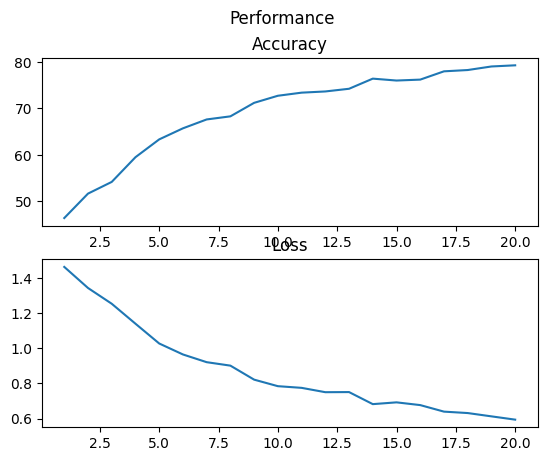

In [51]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1.plot(epochs, acc)
ax1.set_title("Accuracy")

ax2.plot(epochs, loss)
ax2.set_title("Loss")
plt.savefig(f"performance_{int(time.time())}")

In [ ]:
def predict(model):
  model.eval()

  X, label = testD[np.random.randint(len(testD))] # tensor image, label
  
  unnorm = Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])
  img = unnorm(X)
  plt.imshow(img.permute(1, 2, 0))

  X = X.unsqueeze(0).to(DEVICE)
  
  with torch.no_grad():
    pred = model(X).argmax(dim=1).item()

  print(f"Prediction: {model.labels[pred]} ({pred}), Truth: {model.labels[label]} ({label})") 


Prediction: deer (4), Truth: deer (4)


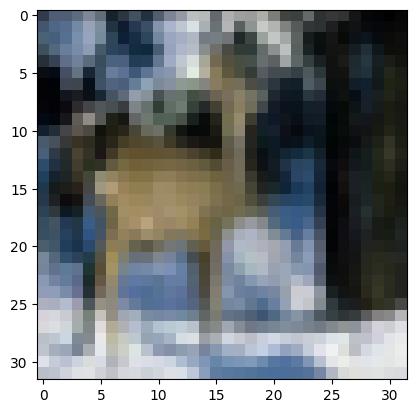

In [81]:
predict(model)